In [2]:
import numpy as np
import os
import cv2
from tqdm import tqdm
from matplotlib import pyplot as plt
import torch
from super_gradients.training import models
import glob
from scipy.optimize import linear_sum_assignment, least_squares

/home/yh6917/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[2023-05-10 21:46:07] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /home/yh6917/sg_logs/console.log


2023-05-10 21:46:08.403889: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-10 21:46:08.547958: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-10 21:46:09.165230: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/yh6917/.local/lib/python3.10/site-packages/cv2/../../lib64:/home/yh6917/nuws/inst

In [9]:
class VO_3D():
    def __init__(self, data_path, feature_method="orb", match_threshold=0.5, iou_threshold=0.5, alpha=0.2):
        self.K, self.P = self._load_calib(os.path.join(data_path, 'calib.txt'))
        self.groundtruth_poses = self._load_poses(os.path.join(data_path, 'poses.txt'))
        self.images = self._load_images(os.path.join(data_path, 'image_l'))
        self.feature_method = feature_method
        self.match_threshold = match_threshold
        self.iou_threshold = iou_threshold
        self.alpha = alpha
        if feature_method == "orb":
            self.feature_detector = cv2.ORB_create(3000)
            FLANN_INDEX_LSH = 6
            index_params = dict(algorithm=FLANN_INDEX_LSH, table_number=6, key_size=12, multi_probe_level=1)
            search_params = dict(checks=50)
        elif feature_method == "sift":
            self.feature_detector = cv2.SIFT_create()
            FLANN_INDEX_KDTREE = 1
            index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
            search_params = dict(checks=50)
        else:
            raise ValueError("Feature method not supported")
        self.flann = cv2.FlannBasedMatcher(indexParams=index_params, searchParams=search_params)

        # object detection related setup
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model = models.get("yolo_nas_s", pretrained_weights="coco").to(self.device)
        self.last_bboxes = None
        self.last_labels = None
    
    @staticmethod
    def _load_calib(filepath):
        with open(filepath, 'r') as f:
            params = np.fromstring(f.readline(), dtype=np.float64, sep=' ')
            P = np.reshape(params, (3, 4))
            K = P[0:3, 0:3]
        return K, P
    
    @staticmethod
    def _load_poses(filepath):
        poses = []
        with open(filepath, 'r') as f:
            for line in f.readlines():
                T = np.fromstring(line, dtype=np.float64, sep=' ')
                T = T.reshape(3, 4)
                poses.append(T)
        return np.array(poses)

    @staticmethod
    def _load_images(filepath):
        images = []
        for filename in sorted(os.listdir(filepath)):
            img = cv2.imread(os.path.join(filepath, filename))
            images.append(img)
        return images
    
    @staticmethod
    def _form_transf(R, t):
        T = np.eye(4)
        T[:3, :3] = R
        T[:3, 3] = t
        return T
    
    def get_matches(self, i):
        kp1, des1 = self.feature_detector.detectAndCompute(self.images[i-1], None)
        kp2, des2 = self.feature_detector.detectAndCompute(self.images[i], None)
        if self.feature_method == "orb":
            matches = self.flann.knnMatch(des1, des2, k=2)
        elif self.feature_method == "sift":
            matches = self.flann.knnMatch(des1.astype(np.float32), des2.astype(np.float32), k=2)
        else:
            raise ValueError("Feature method not supported")

        good_matches = []
        for m, n in matches:
            if m.distance < self.match_threshold * n.distance:
                good_matches.append(m)
        
        q1 = np.array([kp1[m.queryIdx].pt for m in good_matches])
        q2 = np.array([kp2[m.trainIdx].pt for m in good_matches])

        return q1, q2
    
    def get_pose(self, q1, q2):
        # Essential, mask = cv2.findEssentialMat(q1, q2, self.K, cv2.RANSAC, 0.999, 1.0)
        Essential, mask = cv2.findEssentialMat(q1, q2, self.K)
        R, t = self.decompose(Essential, q1, q2)
        return self._form_transf(R, t)
    
    def decompose(self, Essential, q1, q2):
        R1, R2, t = cv2.decomposeEssentialMat(Essential)
        T1 = self._form_transf(R1,np.ndarray.flatten(t))
        T2 = self._form_transf(R2,np.ndarray.flatten(t))
        T3 = self._form_transf(R1,np.ndarray.flatten(-t))
        T4 = self._form_transf(R2,np.ndarray.flatten(-t))
        transformations = [T1, T2, T3, T4]
        K = np.concatenate(( self.K, np.zeros((3,1)) ), axis = 1)
        projections = [K @ T1, K @ T2, K @ T3, K @ T4]
        np.set_printoptions(suppress=True)
        positives = []
        for P, T in zip(projections, transformations):
            hom_Q1 = cv2.triangulatePoints(self.P, P, q1.T, q2.T)
            hom_Q2 = T @ hom_Q1
            Q1 = hom_Q1[:3, :] / hom_Q1[3, :]
            Q2 = hom_Q2[:3, :] / hom_Q2[3, :]  

            total_sum = sum(Q2[2, :] > 0) + sum(Q1[2, :] > 0)
            """
            relative_scale = np.mean(np.linalg.norm(Q1.T[:-1] - Q1.T[1:], axis=-1)/
                                     np.linalg.norm(Q2.T[:-1] - Q2.T[1:], axis=-1))
            """
            relative_scale = np.mean(np.linalg.norm(Q1.T[:-1] - Q1.T[1:], axis=-1) /
                                     (np.linalg.norm(Q2.T[:-1] - Q2.T[1:], axis=-1) + 1e-8))
            positives.append(total_sum + relative_scale)
        max = np.argmax(positives)
        if (max == 2):
            return R1, np.ndarray.flatten(-t)
        elif (max == 3):
            return R2, np.ndarray.flatten(-t)
        elif (max == 0):
            return R1, np.ndarray.flatten(t)
        elif (max == 1):
            return R2, np.ndarray.flatten(t)
    
    def get_objects(self, i):
        # prediction = self.model.predict(self.images[i])
        for item in self.model.predict(self.images[i], conf=0.6)._images_prediction_lst:
            bboxes = item.prediction.bboxes_xyxy
            labels = item.prediction.labels
            return bboxes, labels
        return None, None
    
    def assign_objects(self, bboxes1, bboxes2, labels1, labels2):
        cost_matrix = np.zeros((len(bboxes1), len(bboxes2)))

        for i, bbox1 in enumerate(bboxes1):
            for j, bbox2 in enumerate(bboxes2):
                if labels1[i] == labels2[j]:
                    iou = self.compute_iou(bbox1, bbox2)
                    cost_matrix[i, j] = 1 - iou  # Convert IOU to cost by taking 1 - iou

        row_ind, col_ind = linear_sum_assignment(cost_matrix)

        matches = []
        for i, j in zip(row_ind, col_ind):
            if cost_matrix[i, j] < (1 - self.iou_threshold):
                matches.append((i, j))

        return matches
    
    def get_object_keypoints(self, bboxes):
        keypoints = []
        for bbox in bboxes:
            x1, y1, x2, y2 = bbox
            cx, cy = (x1 + x2) / 2, (y1 + y2) / 2
            keypoints.append([cx, cy])
        return np.array(keypoints)
    
    def compute_iou(self, box1, box2):
        """
        Computes IoU (Intersection over Union) between two bounding boxes
        IoU is a metric for evaluating simularity between two bounding boxes
        IoU is a value between 0 and 1, where 1 means the two bounding boxes are identical
        """
        x1, y1, x2, y2 = box1
        x3, y3, x4, y4 = box2
        x5, y5, x6, y6 = (max(x1, x3), max(y1, y3), min(x2, x4), min(y2, y4))
        if x5 > x6 or y5 > y6:
            return 0
        else:
            intersection = (x6 - x5) * (y6 - y5)
            union = (x2 - x1) * (y2 - y1) + (x4 - x3) * (y4 - y3) - intersection
            return intersection / union
    
    def reprojection_error(self, x, obj_points, img_points, K):
        R, _ = cv2.Rodrigues(x[:3])
        t = x[3:]
        # print("obj_points shape:", obj_points.shape)
        # print("obj_points dtype:", obj_points.dtype)
        proj_points, _ = cv2.projectPoints(obj_points, R, t, K, None)
        # print("proj_points shape:", proj_points.shape)
        proj_points = proj_points.reshape(-1, 2)
        img_points = np.array(img_points, dtype=np.float32)
        # print("proj_points shape:", proj_points.shape)
        # print("img_points shape:", img_points.shape)
        # if img_points.shape != proj_points.shape:
            # img_points = img_points.
        if img_points.shape[0] > proj_points.shape[0]:
            img_points = img_points[:proj_points.shape[0], :]
        error = img_points - proj_points
        return error.ravel()
    
    def get_pose_from_object(self, object_matches, new_bboxes):
        translations = []

        for match in object_matches:
            i, j = match
            bbox1 = self.last_bboxes[i]
            bbox2 = new_bboxes[j]

            centroid1 = np.array([(bbox1[0] + bbox1[2]) / 2, (bbox1[1] + bbox1[3]) / 2])
            centroid2 = np.array([(bbox2[0] + bbox2[2]) / 2, (bbox2[1] + bbox2[3]) / 2])

            translation = centroid2 - centroid1
            translations.append(translation)

        avg_translation = np.mean(translations, axis=0)
        R = np.eye(3)
        t = np.array([avg_translation[0], 0, avg_translation[1]])

        return self._form_transf(R, t)
    

    def plot_trajectory(self, truth_path, estimated_path):
        truth_path = np.array(truth_path)
        estimated_path = np.array(estimated_path)
        fig = plt.figure()
        plt.plot(truth_path[:, 0, 3], truth_path[:, 2, 3], label='Ground Truth')
        plt.plot(estimated_path[:, 0, 3], estimated_path[:, 2, 3], label='Estimated')
        plt.legend()
        plt.show()

    def plot_error(self, truth_path, estimated_path):
        truth_path = np.array(truth_path)
        estimated_path = np.array(estimated_path)
        error = np.linalg.norm(truth_path[:, :3, 3] - estimated_path[:, :3, 3], axis=1)
        plt.plot(error)
        plt.show()
    
    def get_trajectory(self):
        true_path = []
        estimated_path = []
        object_associations = {}
        object_3D_points = {}

        for i, true_pose in enumerate(tqdm(self.groundtruth_poses, unit="frame")):
            if i == 0:
                current_pose = true_pose
                self.last_bboxes, self.last_labels = self.get_objects(i)
            else:
                q1, q2 = self.get_matches(i)
                estimated_pose_from_feature = self.get_pose(q1, q2)

                bboxes, labels = self.get_objects(i)
                object_matches = self.assign_objects(self.last_bboxes, bboxes, self.last_labels, labels)
                
                
                keypoints1 = self.get_object_keypoints(self.last_bboxes)
                keypoints2 = self.get_object_keypoints(bboxes)

                for match in object_matches:
                    obj1_idx, obj2_idx = match
                    obj1_id = self.last_labels[obj1_idx]
                    obj2_id = labels[obj2_idx]

                    if obj1_id not in object_associations:
                        object_associations[obj1_id] = []
                    
                    if obj2_id not in object_associations[obj1_id]:
                        object_associations[obj1_id].append(obj2_id)
                        keypoint1 = keypoints1[obj1_idx]
                        keypoint2 = keypoints2[obj2_idx]

                        P1 = self.P
                        P2 = self.P @ estimated_pose_from_feature

                        hom_3D_point = cv2.triangulatePoints(P1, P2, keypoint1, keypoint2)
                        object_3D_points[obj1_id] = (hom_3D_point / hom_3D_point[3])[0:3]
                        # print("3D point:", object_3D_points[obj1_id])
                        # object_3D_points[obj1_id] = hom_3D_point
                
                curr_frame = self.images[i].copy()
                prev_frame = self.images[i-1].copy()
                # draw bounding boxes on current frame
                # print("bboxes shape:", bboxes.shape)
                for bbox in bboxes:
                    # print("bbox:", bbox)
                    cv2.rectangle(curr_frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 255, 0), 2)
                
                # draw bounding boxes on previous frame
                for bbox in self.last_bboxes:
                    cv2.rectangle(prev_frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 255, 0), 2)
                
                # show both frames
                cv2.imshow("Current Frame", curr_frame)
                cv2.imshow("Last Frame", prev_frame)
                cv2.waitKey(1)

                if len(object_matches) > 0:
                    # img_points_prev = [self.last_bboxes[k] for k, _ in object_matches]
                    object_3D_points_np = np.stack(list(object_3D_points.values()), axis=1).squeeze()
                    # make object_3D_points_np a 2D array of shape (3, N) where N is the number of objects
                    if object_3D_points_np.ndim == 1:
                        object_3D_points_np = np.expand_dims(object_3D_points_np, axis=1)
                    # object_3D_points_np = np.expand_dims(object_3D_points_np, axis=1)
                    # img_points_proj = cv2.projectPoints(object_3D_points_np, estimated_pose_from_feature[:3, :3], estimated_pose_from_feature[:3, 3], self.K, None)[0].reshape(-1, 2)
                    # img_points_curr = [bboxes[k] for _, k in object_matches]
                    img_points_curr = [keypoints2[k] for _, k in object_matches]

                    #print("img_points_curr shape:", np.array(img_points_curr).shape)
                    #print("object_3D_points_np shape:", object_3D_points_np.shape)

                    
                    # Optimize the estimated pose by minimizing the reprojection error
                    initial_guess = np.hstack((cv2.Rodrigues(estimated_pose_from_feature[:3, :3])[0].ravel(), estimated_pose_from_feature[:3, 3]))
                    # reprojection_error = lambda x: self.reprojection_error(x, object_3D_points, img_points_curr, self.K)
                    reprojection_error = lambda x, *args: self.reprojection_error(x, object_3D_points_np, img_points_curr, self.K)

                    res = least_squares(reprojection_error, initial_guess, args=(object_3D_points_np, img_points_curr, self.K), verbose=0)

                    optimized_R, _ = cv2.Rodrigues(res.x[:3])
                    optimized_t = res.x[3:]
                    optimized_pose = self._form_transf(optimized_R, optimized_t)

                    current_pose = np.matmul(current_pose, np.linalg.inv(optimized_pose))
                else:
                    current_pose = np.matmul(current_pose, np.linalg.inv(estimated_pose_from_feature))

                self.last_bboxes = bboxes
                self.last_labels = labels
            
            true_path.append(true_pose)
            estimated_path.append(current_pose)
        
        return true_path, estimated_path

[2023-05-10 21:55:36] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
 98%|█████████▊| 50/51 [00:36<00:00,  1.36frame/s]

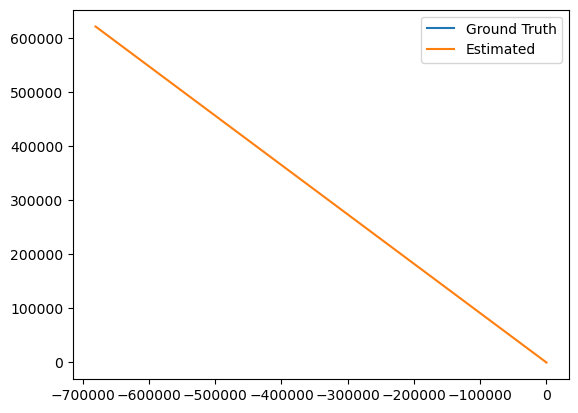

100%|██████████| 51/51 [00:37<00:00,  1.37frame/s]


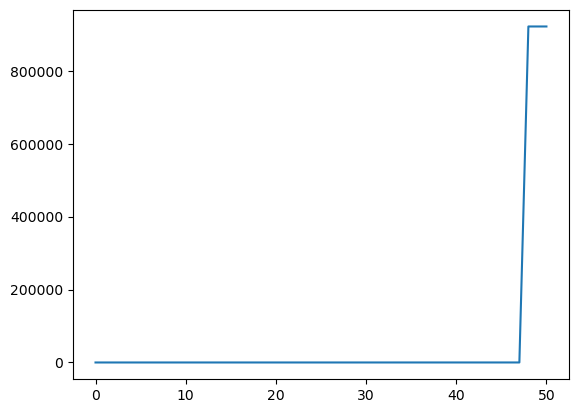

In [10]:
data_path = 'KITTI_sequence_1'
vo = VO_3D(data_path, feature_method='sift')
truth_path, estimated_path = vo.get_trajectory()
vo.plot_trajectory(truth_path, estimated_path)
vo.plot_error(truth_path, estimated_path)